## Practice with YAKE! Keyword Extraction

YAKE! is a light-weight unsupervised automatic keyword extraction method which rests on statistical text features extracted from single documents to select the most relevant keywords of a text. Yake! does not need to be trained on a particular set of documents, nor does it depend on dictionaries, external corpora, text size, language, or domain. 

NOTE: My understanding is that YAKE! is meant to be run on a **single document as a string**. If you have multiple documents, you need to merge them into one single string before using YAKE! In other terms, YAKE! does not seem to take in a list of strings (strings separated by a comma) or a list of lists. 

#### **YAKE! features to note:**

* **Corpus-Independent:** YAKE! offers a solution which can retrieve keywords from a single document only, without the need to rely on external document collection statistics as IDF does; i.e., it can be applied to any text.

* **Domain and Language-Independent:** YAKE! works with domains and languages for which there are no ready keyword extraction systems, as it neither requires a training corpus nor depends on sophisticated external sources (such as WordNet or Wikipedia) or linguistic tools (such as NER or PoS taggers) other than a static list of stopwords.

* **Interior Stopwords:** YAKE! can retrieve keywords containing interior stopwords (e.g., “game of Thrones”) with higher precision than the state-of-the-art methods.

* **Scale:** YAKE! scales to any document length linearly in the number of candidate terms identified.

* **Term Frequency-free:** meaning that no conditions are set with respect to the minimum frequency or sentence frequency that a candidate keyword must have. Therefore, based on the features used, a keyword may be considered significant or insignificant with either one occurrence or with multiple occurrences.

#### **YAKE! has five main steps:** 

1. **Text pre-processing and candidate term identification.** The first step pre-processes the document into a machine-readable format in order to identify potential candidate terms.This is an important and crucial step to identify better candidate terms and thus to improve the effectiveness of the algorithm.

2. **Feature extraction.** The second phase takes as input a list of individual terms and represents them by a set of statistical features.

3. **Computing term score.** In the third step, these features are heuristically combined into a single score likely to reflect the importance of the term.

4. **n-gram generation and computing candidate keyword score.** The fourth step then generates the candidate keywords (through an n-gram7 construction methodology) and assigns them scores, based on their importance.

5. **Data deduplication and ranking.** Finally, the fifth step compares likely similar keywords through the application of a deduplication distance similarity measure. The list of final keywords is then sorted by their relevance scores. 

     

#### **YAKE! References:**

* Yake! on Github: <https://github.com/LIAAD/yake/blob/master/tests/test_yake.py>
* Yake! publication: <https://www.sciencedirect.com/science/article/pii/S0020025519308588>

In [30]:
## Dependencies
import sys, os
import yake
import pandas as pd
from tika import parser # pip install tika
import re
import glob
import numpy as np
import nltk as nltk
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

## Load my dataset
Load the list of pdfs, convert the pdfs to text files, and create a pandas dataframe

In [2]:
directory = "News_Industry"
files = list(glob.glob(os.path.join(directory,'*.*')))
print(files)
#https://stackoverflow.com/questions/34000914/how-to-create-a-list-from-filenames-in-a-user-specified-directory-in-python
#https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
#https://stackoverflow.com/questions/33912773/python-read-txt-files-into-a-dataframe

['News_Industry\\Bibliography.10AGGRESSION AND PHYSICAL HEALTH IN MARRIED WOMEN.pdf', 'News_Industry\\Bibliography.12Impact of Socio-demographic Factors on Awareness of Smoking Effects on Oral Health among Smokers and.pdf', 'News_Industry\\Bibliography.17Health-Promoting Factors related to lifestyle among nursing students in University of Hail.pdf', 'News_Industry\\Bibliography.17Multinomial logit analysis of the effects of five different app-based incentives to encourage cyclin.pdf', 'News_Industry\\Bibliography.1PREVALENCE OF DYSLIPIDEMIA IN YOUNG ADULTS.pdf', 'News_Industry\\Bibliography.20Risk Factors for Atherosclerotic Cardiovascular Disease in the South Asian Population.pdf', 'News_Industry\\Bibliography.29Is the Gay Community the Neo-marginalised of Modern Society_.pdf', 'News_Industry\\Bibliography.33A Biological Effect of Sex Hormone Binding Globulin and Testosterone in Polycystic Ovary Syndrome (P.pdf', 'News_Industry\\Bibliography.34DETERMINANTS OF DEPRESSION ANXIETY STRESS

In [3]:
# Open files, convert from PDF to text file, append each file to a document list
#https://stackoverflow.com/questions/34837707/how-to-extract-text-from-a-pdf-file

document_list = []
for f in files:
    raw = parser.from_file(f)
    document_list.append(raw)

# print(document_list)

In [4]:
## Create a dataframe form the document list
text_df = pd.DataFrame(document_list)
text_df.head()
# print(text_df["content"][1])

,metadata,content,status
0,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200
1,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200
2,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200
3,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200
4,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200


## Test YAKE! on my dataset
This option uses the internal YAKE! preprocessing and stopwords

#### Test Yake on one document in dataframe

In [ ]:
## Test YAKE on one document in dataframe

def test_one_yake(text):
    
    kw_extractor = yake.KeywordExtractor()
    keywords = kw_extractor.extract_keywords(text)

    for kw in keywords:
        print(kw)

test_one_yake(text_df['content'][1])

#The lower the score, the more relevant the keyword is.
#he smaller the value, the more significant the 1-gram term (t) is.

#### Test Yake on all documents in dataframe

In [ ]:
## Test YAKE on all documents in dataframe
#Change dataframe content column in to one long string

def prepare_text(text):
    
    text.dropna(inplace = True)
    
    #initialize empty string
    global string_for_yake
    
    # create string using list comprehension 
    #string_for_yake = ' '.join(text_df['content'].tolist()) 
    
    # create string using list comprehension 
    string_for_yake = ','.join(text_df['content'].tolist()) 
    
    return string_for_yake

prepare_text(text_df) 




In [ ]:
## Run Yake on all-document string

def test_yake(text):
    
    global keywords
    language = "en"
    max_ngram_size = 3
    deduplication_thresold = 0.9
    deduplication_algo = 'seqm'
    windowSize = 1
    numOfKeywords = 500

    custom_kw_extractor = yake.KeywordExtractor(lan=language, 
                                                n=max_ngram_size, 
                                                dedupLim=deduplication_thresold, 
                                                dedupFunc=deduplication_algo, 
                                                windowsSize=windowSize, 
                                                top=numOfKeywords, 
                                                features=None)
    keywords = custom_kw_extractor.extract_keywords(text)

    for kw in keywords:
        print(kw)

test_yake(string_for_yake)

#The lower the score, the more relevant the keyword is.
#he smaller the value, the more significant the 1-gram term (t) is.

In [ ]:
# Save keywords to CSV

def create_keyword_CSV(keywords):
     
    ## Create new dataframe with keywords
    keywords_df = pd.DataFrame(keywords)

    ## Save dataframe to csv
    with open(r"yake_all_documents_only.csv", 'w', encoding='utf-8') as file:
        keywords_df.to_csv(file)
        file.close()
    
create_keyword_CSV(keywords)

## In Excel, use the TRIM() function to change the relevance scores to numbers 
## and then sort by "Sort numbers and numbers stored as text separately"

## Test YAKE! on my dataset

This option uses EXTERNAL pre-processing and stopwords and lemmatization PRIOR to using YAKE!

In [ ]:
## Pre-process the text by lowcase, remove emails, remove URLS, remove special characters and numbers
## https://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.X7RHltBKiUn

def pre_process(text):
    
    # Lowercase
    text_lower = text.lower()
    
    # Remove Emails
    text_email = re.sub('\\S*@\\S*\\s?', '', text_lower) 
    
    # Remove URLS
    text_urls = re.sub(r'http\S+', '', texre.sub("","",text_numbers)t_email)
    
    # Remove all white \t spaces, new lines \n and tabs \t
    text_spaces = re.sub('\s+',' ',text_urls)
    
    # Remove \n from text
    text_space_character = text_spaces.replace('\n','')
    
    # Remove \t from text
    text_tab_character = text_space_character.replace('\t','')
    
    # Remove special characters and numbers
    text_numbers = re.sub("(\\d|\\W)+"," ",text_tab_character)
    
    # Remove tags
    text_final = re.sub("","",text_numbers)

    # Remove special characters and space, but leave in periods and numbers
    #text_special = re.sub('[^A-Za-z0-9.]+|\s',' ',text_tab_character)
    
    return text_final

## New column "preprocess" is formed from applying pre_process function to each item in the "content" column in dataframe
text_df['preprocess'] = text_df['content'].apply(lambda x:pre_process(x))

# print(text_df['preprocess'][1])


In [ ]:
## Get stopwords
def get_stop_words(stop_file_path):
#     """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)

#load a set of stop words
stopwords=get_stop_words("stop_words.txt")

In [ ]:
## Tokenize and lemmatize documents

def split_stop_lemmatize(stopwords, doc_list):
    
    #initiate a lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    #initiate an empty string
    lemmatized_text=''

    #split each doc into words
    for word in doc_list.split():
            
        #check if each word is in stopword list and lemmatize, add to string
        if word not in stopwords:
            lemmatized_text = lemmatized_text+' '+ str(lemmatizer.lemmatize(word))
                
    return lemmatized_text
            
## New column "lemmatized" is formed from applying pre_process function to each item in the "preprocess" column in dataframe

text_df['lemmatized'] = text_df['preprocess'].apply(lambda x:split_stop_lemmatize(stopwords, x))

print(text_df['lemmatized'][1])

In [ ]:
## Convert the "lemmatized" column in dataframe to one long string

def convert_lemmatized_to_string(text_df):
    
    global lemmatized_string_for_yake
    lemmatized_string_for_yake = ' '.join(text_df['lemmatized'].tolist())

    return lemmatized_string_for_yake

convert_lemmatized_to_string(text_df)

## InExcel, use the TRIM() function to change the relevance scores to numbers 
## and then sort by "Sort numbers and numbers stored as text separately"

In [ ]:
## Run Yake on pre-processed, lemmatized string
## https://github.com/LIAAD/yake/blob/master/tests/test_yake.py
## https://www.sciencedirect.com/science/article/pii/S0020025519308588?via%3Dihub

def test_yake_preprocessed_lemmatized(text):
    global keywords
    language = "en"
    max_ngram_size = 3
    deduplication_thresold = 0.9
    deduplication_algo = 'seqm'
    windowSize = 1
    numOfKeywords = 200

    custom_kw_extractor = yake.KeywordExtractor(lan=language, 
                                                n=max_ngram_size, 
                                                dedupLim=deduplication_thresold, 
                                                dedupFunc=deduplication_algo, 
                                                windowsSize=windowSize, 
                                                top=numOfKeywords, 
                                                features=None)
    keywords = custom_kw_extractor.extract_keywords(text)

#     for kw in keywords:
#         print(kw)
    return keywords

test_yake_preprocessed_lemmatized(lemmatized_string_for_yake)

## The lower the score, the more relevant the keyword is.


In [ ]:
# Save keywords to CSV

def create_keyword_CSV(keywords):
     
    ## Create new dataframe with keywords
    keywords_df = pd.DataFrame(keywords)

    ## Save dataframe to csv
    with open(r"yake_all_documents_preprocess_lemmatization.csv", 'w', encoding='utf-8') as file:
        keywords_df.to_csv(file)
        file.close()
    
create_keyword_CSV(keywords)

## In Excel, use the TRIM() function to change the relevance scores to numbers 
## and then sort by "Sort numbers and numbers stored as text separately"

## Test YAKE! on my dataset

This option runs Yake individual on each document in dataframe and uses external pre-processing ONLY

THIS IS THE BEST ROUTE, IN MY OPINION

In [5]:
## Pre-process the text by lowcase, remove emails, remove URLS, remove special characters and numbers
#https://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.X7RHltBKiUn

def pre_process(text):
    
    ## Lowercase words
    text_lower = text.lower()
    
    ## Remove Emails from text
    ## if you need to match a \, you can precede them with a backslash to remove their special meaning: \\.
    ## \S matches any non-whitespace character; this is equivalent to the class [^ \t\n\r\f\v].
    ## \s Matches any whitespace character; this is equivalent to the class [ \t\n\r\f\v]
    ## Code below matches any character, then an @ sign, then more characters, end matching when a white space is found.
    text_email = re.sub('\\S*@\\S*\\s?', '', text_lower) 
    
    ## Remove URLS from text
    ## https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/40823105#40823105
    ## text_urls = re.sub(r'http\S+', '', text_email)
    ## https://www.geeksforgeeks.org/python-check-url-string/
    text_urls = re.sub(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))",'', text_email)
    
    
    ## Remove tabs and new lines from text
    ## https://stackoverflow.com/questions/16355732/how-to-remove-tabs-and-newlines-with-a-regex
    ## \s Matches any whitespace character; this is equivalent to the class [ \t\n\r\f\v]
    text_spaces = re.sub(r'\s+',' ',text_urls)
        
    ## Remove \n from text
    text_space_character = text_spaces.replace('\n','')
    
    ## Remove \t from text
    text_tab_character = text_space_character.replace('\t','')
    
    ## Remove special characters and numbers
    ## \W matches any non-alphanumeric character; this is equivalent to the class [^a-zA-Z0-9_]
    ## \d matches any decimal digit; this is equivalent to the class [0-9]
    text_final = re.sub("(\\d|\\W)+"," ",text_tab_character)
    
    ## Remove tags
    ##text_tags = re.sub("","",text_numbers)

    ## Remove special characters and space, but leave in periods and numbers
    ## ^ means any character except. So [^5] will match any character except '5'
    ## [^a-zA-Z0-9_] matches any non-alphanumeric character.
    ## text_special = re.sub('[^A-Za-z0-9.]+|\s',' ',text_tab_character)
   
    
    
    return text_final

## New column "preprocess" is formed from applying pre_process function to each item in the "content" column in dataframe
text_df['preprocess_only'] = text_df['content'].apply(lambda x:pre_process(x))

print(text_df['preprocess_only'][0])

 aggression and physical health in married women aggression and physical health in married women journal of postgraduate medical institute december tuesday copyright postgraduate medical institute all rights reserved section vol no length words byline faiza shafique and riffat sadiq body keywords aggression health women introduction aggression is an instinctive drive of a person and a dark side of human nature it includes a variety of range of behaviors aggression involves verbal and physical assault therefore its expression results in intense violence towards others aggression is an unwanted and maladaptive behavior causing damage and obliteration it is exhibited in different forms encompassing physical aggression verbal aggression anger and hostility a person with physical aggression causing physical and emotional harm others while harming or hurting someone verbally is described as verbal aggression anger involves physiological activation determining emotional and affective state ho

In [6]:
## Test YAKE on all documents in dataframe
#Change dataframe content column in to one long string

def prepare_text(text):
    
    text.dropna(inplace = True)
    
    #initialize empty string
    global string_for_yake
    
    # create string using list comprehension 
    #string_for_yake = ' '.join(text_df['preprocess_only'].tolist()) 
    
     # create string using list comprehension 
    string_for_yake = ','.join(text_df['preprocess_only'].tolist()) 
    
    return string_for_yake

prepare_text(text_df) 


' aggression and physical health in married women aggression and physical health in married women journal of postgraduate medical institute december tuesday copyright postgraduate medical institute all rights reserved section vol no length words byline faiza shafique and riffat sadiq body keywords aggression health women introduction aggression is an instinctive drive of a person and a dark side of human nature it includes a variety of range of behaviors aggression involves verbal and physical assault therefore its expression results in intense violence towards others aggression is an unwanted and maladaptive behavior causing damage and obliteration it is exhibited in different forms encompassing physical aggression verbal aggression anger and hostility a person with physical aggression causing physical and emotional harm others while harming or hurting someone verbally is described as verbal aggression anger involves physiological activation determining emotional and affective state h

In [7]:
def test_yake_preprocessed_only(text):
    
    #print(type(text))
    global keywords
    language = "en"
    max_ngram_size = 3
    deduplication_thresold = 0.9
    deduplication_algo = 'seqm'
    windowSize = 1
    numOfKeywords = 500

    custom_kw_extractor = yake.KeywordExtractor(lan=language, 
                                                n=max_ngram_size, 
                                                dedupLim=deduplication_thresold, 
                                                dedupFunc=deduplication_algo, 
                                                windowsSize=windowSize, 
                                                top=numOfKeywords, 
                                                features=None)
    keywords = custom_kw_extractor.extract_keywords(text)

#     for kw in keywords:
#         print(kw)
    return keywords

test_yake_preprocessed_only(string_for_yake)



[('cardiovascular risk factors', 7.157481958399322e-09),
 ('years years years', 1.470842998760603e-08),
 ('coronary artery risk', 1.477156002723744e-08),
 ('significant risk factors', 1.901853901594084e-08),
 ('disease risk factors', 1.9545252783679986e-08),
 ('coronary artery disease', 2.1410816871848786e-08),
 ('adults cardia study', 2.3488174352308562e-08),
 ('psychological risk factors', 2.351356598870742e-08),
 ('young adults study', 2.3599031551534226e-08),
 ('coronary heart disease', 2.4185522565633847e-08),
 ('artery risk development', 2.642904326980215e-08),
 ('cardiovascular disease risk', 2.8495708175537148e-08),
 ('lifestyle risk factors', 3.424645744510711e-08),
 ('behavioral risk factor', 3.473740305583326e-08),
 ('body mass index', 3.748973867145364e-08),
 ('cardiovascular disease diseases', 4.300961160452904e-08),
 ('age age age', 4.499656857801804e-08),
 ('year year year', 4.6576694960752423e-08),
 ('young adults cardia', 4.9284611817894696e-08),
 ('coronary risk facto

In [ ]:
## Inspect the results
print(type(keywords))
print(keywords[0])

In [8]:
# Save keywords to CSV

def create_keyword_CSV(keywords):
     
    ## Create new dataframe with keywords
    keywords_df = pd.DataFrame(keywords)

    ## Save dataframe to csv
    with open(r"yake_all_documents_preprocess_only.csv", 'w', encoding='utf-8') as file:
        keywords_df.to_csv(file)
        file.close()
        
    return keywords_df
    
create_keyword_CSV(keywords)

## In Excel, use the TRIM() function to change the relevance scores to numbers 
## and then sort by "Sort numbers and numbers stored as text separately"

,0,1
0,cardiovascular risk factors,7.157482e-09
1,years years years,1.470843e-08
2,coronary artery risk,1.477156e-08
3,significant risk factors,1.901854e-08
4,disease risk factors,1.954525e-08
...,...,...
495,cardiovascular disease women,8.094709e-07
496,hypertension physical activity,8.100123e-07
497,cardiovascular risk metabolic,8.125018e-07
498,weight loss study,8.149848e-07


In [22]:
# Generate a word cloud image
## https://www.datacamp.com/community/tutorials/wordcloud-python

#global term_relevance_tuple
## Make a tuple of (term,weight).

def convert(list): 
    global term_relevance_tuple
    term_relevance_tuple = tuple(list)
    return term_relevance_tuple

convert(keywords)
print(type(term_relevance_tuple))


<class 'tuple'>


In [41]:
import operator
from collections import OrderedDict
## Make a dicitonary from the keyword list
term_relevance_dict = dict(keywords)

#print(term_relevance_dict)
## The dict constructor accepts an iterable of two-element-iterables.

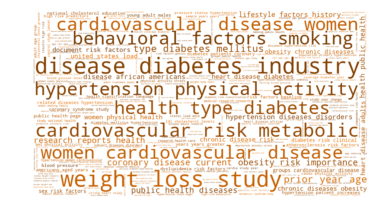

In [53]:
# Generate the cloud

wordcloud = WordCloud(background_color="white", width=900,height=500, max_words=500,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(term_relevance_dict)

#change the color setting
#change the value in return to set the single color need, in hsl format.
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 21.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(np.random.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud.recolor(color_func = random_color_func)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('news_industry.png')
plt.show()



## Test YAKE! 
This option uses text from YAKE tutorials in github

In [ ]:
def test_simple_interface_1():
    text_content = """
    Sources tell us that Google is acquiring Kaggle, a platform that
    hosts data science and machine learning competitions. Details about
    the transaction remain somewhat vague , but given that Google is hosting
    its Cloud Next conference in San Francisco this week, the official announcement
    could come as early    as tomorrow.  Reached by phone, Kaggle co-founder
    CEO Anthony Goldbloom declined to deny that the
    acquisition is happening. Google itself declined 'to comment on rumors'.
    Kaggle, which has about half a million data scientists on its platform,
    was founded by Goldbloom    and Ben Hamner in 2010. The service got an
    early start and even though it has a few competitors    like DrivenData,
    TopCoder and HackerRank, it has managed to stay well ahead of them by focusing on its
    specific niche. The service is basically the de facto home for running data science
    and machine learning    competitions.  With Kaggle, Google is buying one of the largest
    and most active communities for    data scientists - and with that, it will get increased
    mindshare in this community, too    (though it already has plenty of that thanks to Tensorflow
    and other projects).    Kaggle has a bit of a history with Google, too, but that's pretty recent.
    Earlier this month,    Google and Kaggle teamed up to host a $100,000 machine learning competition
    around classifying    YouTube videos. That competition had some deep integrations with the
    Google Cloud Platform, too.    Our understanding is that Google will keep the service running -
    likely under its current name.    While the acquisition is probably more about Kaggle's community
    than technology, Kaggle did build    some interesting tools for hosting its competition and 'kernels',
    too. On Kaggle, kernels are    basically the source code for analyzing data sets and developers can
    share this code on the    platform (the company previously called them 'scripts').  Like similar
    competition-centric sites,    Kaggle also runs a job board, too. It's unclear what Google will do
    with that part of the service.    According to Crunchbase, Kaggle raised $12.5 million (though PitchBook
    says it's $12.75) since its    launch in 2010. Investors in Kaggle include Index Ventures, SV Angel,
    Max Levchin, Naval Ravikant,    Google chief economist Hal Varian, Khosla Ventures and Yuri Milner
    """

    pyake = yake.KeywordExtractor(lan="en",n=3)

    result = pyake.extract_keywords(text_content)

    print(result)

    keywords = [kw[0] for kw in result]

    print(keywords)
    assert "google" in keywords
    assert "kaggle" in keywords
    assert "san francisco" in keywords
    assert "machine learning" in keywords

test_simple_interface_1()

In [ ]:
def test_simple_interface_2():
    text_content = """
    Sources tell us that Google is acquiring Kaggle, a platform that
    hosts data science and machine learning competitions."""

    pyake = yake.KeywordExtractor(lan="ca",n=3)

    result = pyake.extract_keywords(text_content)

    print(result)

    assert len(result) > 0

test_simple_interface_2()

In [ ]:
def test_simple_interface_3():
    text = "Sources tell us that Google is acquiring Kaggle, a platform that hosts data science and machine learning "\
    "competitions. Details about the transaction remain somewhat vague, but given that Google is hosting its Cloud "\
    "Next conference in San Francisco this week, the official announcement could come as early as tomorrow. "\
    "Reached by phone, Kaggle co-founder CEO Anthony Goldbloom declined to deny that the acquisition is happening. "\
    "Google itself declined 'to comment on rumors'. Kaggle, which has about half a million data scientists on its platform, "\
    "was founded by Goldbloom  and Ben Hamner in 2010. "\
    "The service got an early start and even though it has a few competitors like DrivenData, TopCoder and HackerRank, "\
    "it has managed to stay well ahead of them by focusing on its specific niche. "\
    "The service is basically the de facto home for running data science and machine learning competitions. "\
    "With Kaggle, Google is buying one of the largest and most active communities for data scientists - and with that, "\
    "it will get increased mindshare in this community, too (though it already has plenty of that thanks to Tensorflow "\
    "and other projects). Kaggle has a bit of a history with Google, too, but that's pretty recent. Earlier this month, "\
    "Google and Kaggle teamed up to host a $100,000 machine learning competition around classifying YouTube videos. "\
    "That competition had some deep integrations with the Google Cloud Platform, too. Our understanding is that Google "\
    "will keep the service running - likely under its current name. While the acquisition is probably more about "\
    "Kaggle's community than technology, Kaggle did build some interesting tools for hosting its competition "\
    "and 'kernels', too. On Kaggle, kernels are basically the source code for analyzing data sets and developers can "\
    "share this code on the platform (the company previously called them 'scripts'). "\
    "Like similar competition-centric sites, Kaggle also runs a job board, too. It's unclear what Google will do with "\
    "that part of the service. According to Crunchbase, Kaggle raised $12.5 million (though PitchBook says it's $12.75) "\
    "since its   launch in 2010. Investors in Kaggle include Index Ventures, SV Angel, Max Levchin, Naval Ravikant, "\
    "Google chief economist Hal Varian, Khosla Ventures and Yuri Milner "
    
    kw_extractor = yake.KeywordExtractor()
    keywords = kw_extractor.extract_keywords(text)

    for kw in keywords:
        print(kw)

test_simple_interface_3()

In [ ]:
def test_simple_interface_4():
    
    text = "Sources tell us that Google is acquiring Kaggle, a platform that hosts data science and machine learning "\
    "competitions. Details about the transaction remain somewhat vague, but given that Google is hosting its Cloud "\
    "Next conference in San Francisco this week, the official announcement could come as early as tomorrow. "\
    "Reached by phone, Kaggle co-founder CEO Anthony Goldbloom declined to deny that the acquisition is happening. "\
    "Google itself declined 'to comment on rumors'. Kaggle, which has about half a million data scientists on its platform, "\
    "was founded by Goldbloom  and Ben Hamner in 2010. "\
    "The service got an early start and even though it has a few competitors like DrivenData, TopCoder and HackerRank, "\
    "it has managed to stay well ahead of them by focusing on its specific niche. "\
    "The service is basically the de facto home for running data science and machine learning competitions. "\
    "With Kaggle, Google is buying one of the largest and most active communities for data scientists - and with that, "\
    "it will get increased mindshare in this community, too (though it already has plenty of that thanks to Tensorflow "\
    "and other projects). Kaggle has a bit of a history with Google, too, but that's pretty recent. Earlier this month, "\
    "Google and Kaggle teamed up to host a $100,000 machine learning competition around classifying YouTube videos. "\
    "That competition had some deep integrations with the Google Cloud Platform, too. Our understanding is that Google "\
    "will keep the service running - likely under its current name. While the acquisition is probably more about "\
    "Kaggle's community than technology, Kaggle did build some interesting tools for hosting its competition "\
    "and 'kernels', too. On Kaggle, kernels are basically the source code for analyzing data sets and developers can "\
    "share this code on the platform (the company previously called them 'scripts'). "\
    "Like similar competition-centric sites, Kaggle also runs a job board, too. It's unclear what Google will do with "\
    "that part of the service. According to Crunchbase, Kaggle raised $12.5 million (though PitchBook says it's $12.75) "\
    "since its   launch in 2010. Investors in Kaggle include Index Ventures, SV Angel, Max Levchin, Naval Ravikant, "\
    "Google chief economist Hal Varian, Khosla Ventures and Yuri Milner "
    
    print(type(text))
    language = "en"
    max_ngram_size = 3
    deduplication_thresold = 0.9
    deduplication_algo = 'seqm'
    windowSize = 1
    numOfKeywords = 20

    custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_thresold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None)
    keywords = custom_kw_extractor.extract_keywords(text)

    for kw in keywords:
        print(kw)

test_simple_interface_4()